In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
import optuna
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn import svm
import lightgbm as ltb
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
df = pd.read_csv('train.csv').set_index('id')
df.describe()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
count,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000,5407.000000
mean,299.168189,58.610579,31.872795,185.076235,4.108441,992.000718,771.219974,51.751618,35.452071
std,105.537682,83.417801,54.605003,18.517583,5.692296,77.148010,78.725253,70.006975,16.401896
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,213.700000,0.000000,0.000000,175.100000,0.000000,938.200000,734.300000,7.000000,23.640000
50%,297.200000,0.000000,0.000000,187.400000,0.000000,978.000000,781.200000,28.000000,33.950000
75%,375.000000,122.600000,79.000000,192.000000,8.050000,1047.000000,821.000000,56.000000,45.850000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


<AxesSubplot:>

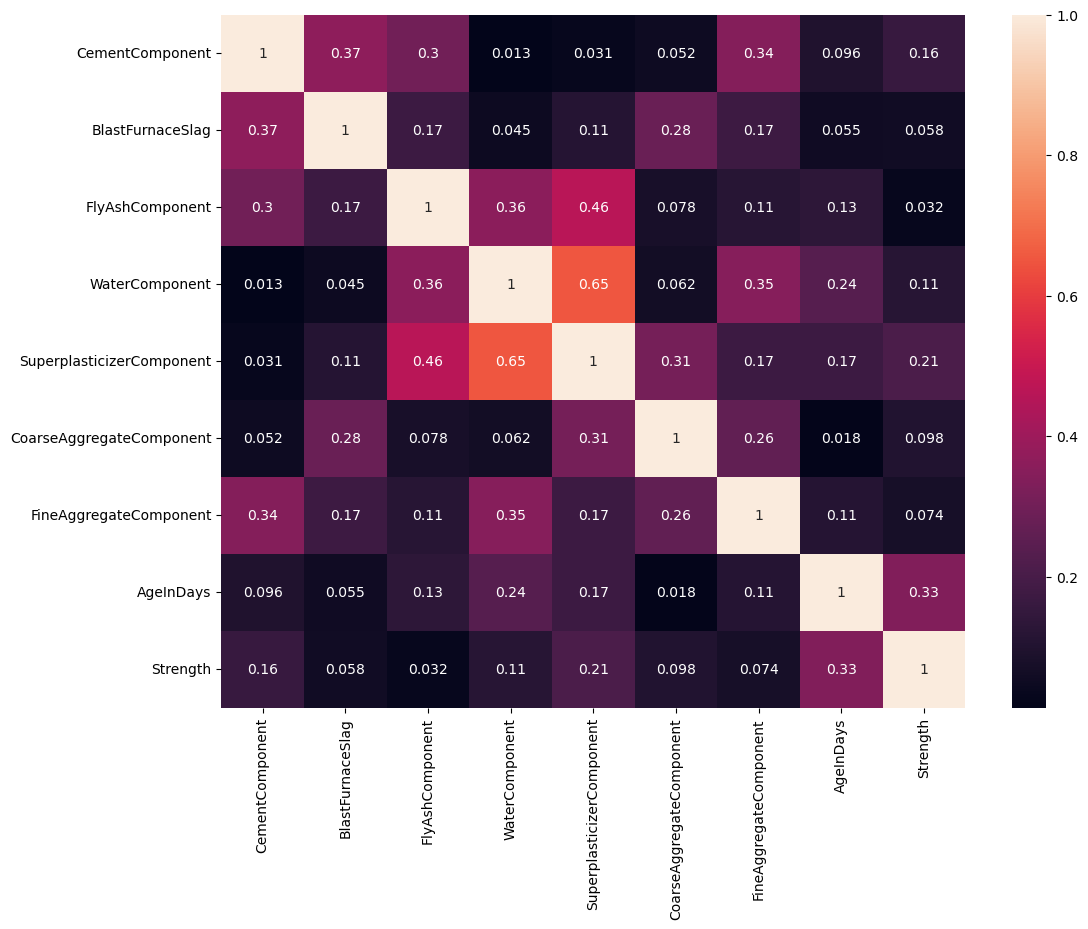

In [3]:
fig, ax = plt.subplots(figsize=(12,9))
sns.heatmap(abs(df.corr()), annot=True)

In [4]:
df_test = pd.read_csv('test.csv').set_index('id')
df_test.describe()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays
count,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000,3605.000000
mean,299.943523,55.803273,32.829154,184.345825,4.194230,990.222330,774.736311,49.153398
std,104.809283,80.938863,55.490684,17.964842,5.807567,76.812197,77.412505,63.564334
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000
25%,213.800000,0.000000,0.000000,174.900000,0.000000,938.200000,739.300000,7.000000
50%,300.000000,0.000000,0.000000,188.500000,0.000000,977.600000,781.500000,28.000000
75%,374.000000,117.200000,90.000000,192.000000,8.100000,1047.000000,821.000000,56.000000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000


In [5]:
#checking for any nan values
print(df.isnull().values.any())
print(df_test.isnull().values.any())

False
False


# Dividing data for model training

In [6]:
X = df.drop('Strength',axis=1)
y = df['Strength']

In [7]:
X_test = df_test
X_test.head()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays
id,,,,,,,,
5407,166.1,75.4,163.8,173.8,4.6,1007.2,746.6,56
5408,304.0,0.0,0.0,190.0,0.0,998.0,801.0,7
5409,225.0,0.0,0.0,185.0,0.0,1113.0,833.0,28
5410,251.4,0.0,118.3,188.5,6.4,1028.4,757.7,100
5411,144.0,15.0,195.0,176.0,6.0,1021.0,709.0,28


# XGB model

In [8]:
# def xbg_opt(x):
#     #est = x.suggest_int('n_estimators', 1500, 3000)
#     learning_rate = x.suggest_float('learning_rate', 0, 0.008)
#     subsample = x.suggest_float('subsample', 0.6, 1)
#     depth = x.suggest_int('max_depth', 3, 10)
#     xgb = XGBRegressor(n_estimators=3000, max_depth=depth,
#                        eta=learning_rate, subsample = subsample)
    
#     X_train, X_true, y_train, y_true = train_test_split(X, y, test_size=0.25, random_state=42)
    
#     xgb.fit(X_train, y_train)
#     xgb_preds = xgb.predict(X_true)

#     return mean_squared_error(y_true, xgb_preds, squared = False)

# study = optuna.create_study(direction= 'minimize')
# study.optimize(xbg_opt, n_trials= 100)

# study.best_params

In [9]:
k_fold = KFold(n_splits=5)

modelsXGB = []
predsXGB = []
xgbr_params = dict(n_estimators=3000, max_depth=4,
                   eta=0.0016871856953315112, subsample = 0.7198403750944147,
                   tree_method = 'gpu_hist')

for train_index, test_index in k_fold.split(X,y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
  
    xgb = XGBRegressor(**xgbr_params)
    
    xgb.fit(X=X_train, y=y_train, eval_set=[(X_valid, y_valid)],
    early_stopping_rounds = 100, verbose = False)

    xgb_preds = xgb.predict(X_test)
    
    modelsXGB.append(xgb)
    predsXGB.append(xgb_preds)

# Catboost model

In [10]:
# def cb_opt(x):
#     # iterations = x.suggest_int('iterations', 1500, 3000)
#     learning_rate = x.suggest_float('learning_rate', 0, 0.05)
#     subsample = x.suggest_float('subsample', 0.5, 1)
#     # depth =  x.suggest_int('depth', 3, 10)
#     reg = x.suggest_float('reg', 0, 1)
#     cb = CatBoostRegressor(iterations=2500, learning_rate=learning_rate, 
#                            depth=5, verbose=False, subsample = subsample, 
#                            l2_leaf_reg=reg)
    
#     X_train, X_true, y_train, y_true = train_test_split(X, y, test_size=0.2, random_state=42)
    
    
#     cb.fit(X_train, y_train)
#     cb_preds = cb.predict(X_true)

#     return mean_squared_error(y_true, cb_preds, squared = False)

# study = optuna.create_study(direction= 'minimize')
# study.optimize(cb_opt, n_trials= 100)

# study.best_params

In [11]:
k_fold = KFold(n_splits=5)

modelsCB = []
predsCB = []
cbr_params = dict(iterations=2500, max_depth=5,
                  learning_rate = 0.0033882877566152616, subsample = 0.8953685117189872,
                  task_type = 'GPU', l2_leaf_reg = 0.714399266280004, verbose = False, 
                  bootstrap_type='Poisson')

for train_index, test_index in k_fold.split(X,y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
  
    cb = CatBoostRegressor(**cbr_params)
    
    cb.fit(X=X_train, y=y_train, eval_set=[(X_valid, y_valid)],
    early_stopping_rounds = 100)

    cb_preds = cb.predict(X_test)
    
    modelsCB.append(cb)
    predsCB.append(cb_preds)

# Random Forest model

In [12]:
# def rf_opt(x):
#     depth = x.suggest_int('max_depth', 5, 10)
#     max_features = x.suggest_int('max_features', 2, 8)
#     min_samples_leaf = x.suggest_int('min_samples_leaf', 5, 50)
#     rf = RandomForestRegressor(n_estimators = 2000, criterion = 'squared_error', max_depth = depth, 
#                                max_features = max_features, min_samples_leaf = min_samples_leaf)
    
    
#     X_train, X_true, y_train, y_true = train_test_split(X, y, test_size=0.2, random_state=42)
    
    
#     rf.fit(X_train, y_train)
#     rf_preds = rf.predict(X_true)

#     return mean_squared_error(y_true, rf_preds, squared = False)

# study = optuna.create_study(direction= 'minimize')
# study.optimize(rf_opt, n_trials= 100)

# study.best_params

In [13]:
k_fold = KFold(n_splits=5)

modelsRF = []
predsRF = []

rfr_params = dict(n_estimators=2000, max_depth=6,
                  max_features = 7, verbose = False, 
                  min_samples_leaf = 15)

for train_index, test_index in k_fold.split(X,y):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
  
    rf = RandomForestRegressor(**rfr_params)
    
    rf.fit(X=X_train, y=y_train)

    rf_preds = rf.predict(X_test)
    
    modelsRF.append(rf)
    predsRF.append(rf_preds)

# LASSO model

In [14]:
from sklearn.linear_model import LassoCV, Lasso

In [15]:
# def lasso_opt(x):
#     eps = x.suggest_float('eps', 0, 0.001)
#     cv = x.suggest_int('cv', 2, 5)
#     n_alphas = x.suggest_int('n_alphas', 1000, 2000)
#     alpha = x.suggest_float('alpha', 0, 0.1)
#     tol = x.suggest_float('tol', 0, 0.01)
#     lasso = LassoCV(precompute = 'auto', fit_intercept = True,
#                     normalize = False, max_iter = 10000, eps = eps, 
#                     cv = cv, n_alphas = n_alphas, n_jobs = 8,
#                     tol = tol)
#     lasso_par = {
#          'alpha': alpha,
#          'max_iter': 10000,
#          'tol': tol    
#      }
    
#     X_train, X_true, y_train, y_true = train_test_split(X, y, test_size=0.25, random_state=42)
    
    
#     lasso.fit(X_train, y_train)
#     lasso_preds = lasso.predict(X_true)

#     return mean_squared_error(y_true, lasso_preds, squared = False)

# study = optuna.create_study(direction= 'minimize')
# study.optimize(lasso_opt, n_trials= 100)

# study.best_params

In [16]:
k_fold = KFold(n_splits=5)

modelsLasso = []
predsLasso = []

lasso_params = dict(alpha = 0.011331309463411023, max_iter = 10000, tol = 0.009713287632154238)

lassocv_params = dict(precompute = 'auto', fit_intercept = True,
                    normalize = False, max_iter = 10000, eps = 0.00043732786136795276, 
                    cv = 5, n_alphas = 1742, n_jobs = 8,
                    tol = 0.009713287632154238)

for train_index, test_index in k_fold.split(X,y):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
  
    lasso = Lasso(**lasso_params)
    
    lasso.fit(X=X_train, y=y_train)

    lasso_preds = lasso.predict(X_test)
    
    modelsLasso.append(lasso)
    predsLasso.append(lasso_preds)

# Support Vector Regression

In [17]:
# def SVR_opt(x):
#     tol = x.suggest_float('tol', 0, 0.001)
#     C = x.suggest_float('C', 0.98, 1.05)
#     eps = x.suggest_float('epsilon', 0.005, 0.02)
#     SVR = svm.SVR(tol = tol, C = C, epsilon = eps, gamma = 0.001)
    
#     X_train, X_true, y_train, y_true = train_test_split(X, y, test_size=0.25, random_state=42)
    
    
#     SVR.fit(X_train, y_train)
#     svr_preds = SVR.predict(X_true)

#     return mean_squared_error(y_true, svr_preds, squared = False)

# study = optuna.create_study(direction= 'minimize')
# study.optimize(SVR_opt, n_trials= 100)

# study.best_params

In [18]:
k_fold = KFold(n_splits=5)

modelsSVR = []
predsSVR = []


svr_params = dict(tol = 0.0007618119753298281, C = 1.049996968413195, 
                  epsilon = 0.015552737698416759, gamma = 0.001)

for train_index, test_index in k_fold.split(X,y):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
  
    SVR = svm.SVR(**svr_params)
    
    SVR.fit(X=X_train, y=y_train)

    SVR_preds = SVR.predict(X_test)
    
    modelsSVR.append(SVR)
    predsSVR.append(SVR_preds)

# LightGBM regressor model

In [19]:
# def LGBM_opt(x):
#     learning_rate = x.suggest_float('learning_rate', 0.001, 0.01)
#     #reg_alpha = x.suggest_float('reg_alpha', 0.001, 0.015)
#     #reg_lambda = x.suggest_float('reg_lambda', 0.001, 0.015)
#     #num_leaves = x.suggest_int('num_leaves', 5, 20)
#     subsample = x.suggest_float('subsample', 0.5, 1)
#     lambda_l1 = x.suggest_int('lambda_l1', 1, 6)
#     lambda_l2 = x.suggest_int('lambda_l2', 1, 6)
#     LGBM = ltb.LGBMRegressor(n_estimators = 1000, num_leaves = 9, learning_rate = learning_rate,
#                              lambda_l1 = lambda_l1, lambda_l2 = lambda_l2 , max_depth = 10,
#                              subsample = subsample, feature_fraction = 0.8, bagging_fraction = 0.8,
#                              device = 'gpu')
    
#     X_train, X_true, y_train, y_true = train_test_split(X, y, test_size=0.33, random_state=42)
     
#     LGBM.fit(X_train, y_train)
#     lgbm_preds = LGBM.predict(X_true)

#     return mean_squared_error(y_true, lgbm_preds, squared = False)

# study = optuna.create_study(direction= 'minimize')
# study.optimize(LGBM_opt, n_trials= 100)

# study.best_params

In [20]:
k_fold = KFold(n_splits=5)

modelsLGBM = []
predsLGBM = []


lgbm_params = dict(n_estimators = 1000, num_leaves = 9, learning_rate = 0.009121343086184033,
                             lambda_l1 = 4, lambda_l2 = 3 , max_depth = 10,
                             subsample = 0.9410521882109187, feature_fraction = 0.8, bagging_fraction = 0.8,
                             device = 'gpu')

for train_index, test_index in k_fold.split(X,y):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
  
    LGBM = ltb.LGBMRegressor(**lgbm_params)
    
    LGBM.fit(X=X_train, y=y_train, eval_set=[(X_valid, y_valid)],
          early_stopping_rounds = 100, verbose = False)

    LGBM_preds = LGBM.predict(X_test)
    
    modelsLGBM.append(LGBM)
    predsLGBM.append(LGBM_preds)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9410521882109187 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=4, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9410521882109187 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Cu

# Keras Neural Network

In [21]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1152      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 166,017
Trainable params: 166,017
Non-trainable params: 0
_________________________________________________________________


In [22]:
checkpoint_name = 'Weights-{epoch}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 10, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [23]:
NN_model.fit(X, y, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/500
112/136 [=======================>......] - ETA: 0s - loss: 12.5610 - mean_absolute_error: 12.5610
Epoch 1: val_loss improved from inf to 12.26200, saving model to Weights-1--12.26200.hdf5
136/136 [==============================] - 1s 3ms/step - loss: 12.3642 - mean_absolute_error: 12.3642 - val_loss: 12.2620 - val_mean_absolute_error: 12.2620
Epoch 2/500
114/136 [========================>.....] - ETA: 0s - loss: 10.9337 - mean_absolute_error: 10.9337
Epoch 2: val_loss improved from 12.26200 to 10.95823, saving model to Weights-2--10.95823.hdf5
136/136 [==============================] - 0s 2ms/step - loss: 10.9184 - mean_absolute_error: 10.9184 - val_loss: 10.9582 - val_mean_absolute_error: 10.9582
Epoch 3/500
117/136 [========================>.....] - ETA: 0s - loss: 10.3720 - mean_absolute_error: 10.3720
Epoch 3: val_loss improved from 10.95823 to 10.54099, saving model to Weights-3--10.54099.hdf5
136/136 [==============================] - 0s 2ms/step - loss: 10.2972 - mea

136/136 [==============================] - 0s 2ms/step - loss: 9.3614 - mean_absolute_error: 9.3614 - val_loss: 10.4983 - val_mean_absolute_error: 10.4983
Epoch 27/500
121/136 [=========================>....] - ETA: 0s - loss: 9.3566 - mean_absolute_error: 9.3566
Epoch 27: val_loss did not improve from 9.82375
136/136 [==============================] - 0s 2ms/step - loss: 9.3874 - mean_absolute_error: 9.3874 - val_loss: 11.6776 - val_mean_absolute_error: 11.6776
Epoch 28/500
121/136 [=========================>....] - ETA: 0s - loss: 9.4346 - mean_absolute_error: 9.4346
Epoch 28: val_loss did not improve from 9.82375
136/136 [==============================] - 0s 2ms/step - loss: 9.4779 - mean_absolute_error: 9.4779 - val_loss: 9.9774 - val_mean_absolute_error: 9.9774
Epoch 29/500
121/136 [=========================>....] - ETA: 0s - loss: 9.4031 - mean_absolute_error: 9.4031
Epoch 29: val_loss did not improve from 9.82375
136/136 [==============================] - 0s 2ms/step - loss: 9.4

Epoch 53/500
119/136 [=========================>....] - ETA: 0s - loss: 9.2457 - mean_absolute_error: 9.2457
Epoch 53: val_loss did not improve from 9.79795
136/136 [==============================] - 0s 2ms/step - loss: 9.1557 - mean_absolute_error: 9.1557 - val_loss: 10.1536 - val_mean_absolute_error: 10.1536
Epoch 54/500
120/136 [=========================>....] - ETA: 0s - loss: 9.1831 - mean_absolute_error: 9.1831
Epoch 54: val_loss did not improve from 9.79795
136/136 [==============================] - 0s 2ms/step - loss: 9.2379 - mean_absolute_error: 9.2379 - val_loss: 10.0024 - val_mean_absolute_error: 10.0024
Epoch 55/500
118/136 [=========================>....] - ETA: 0s - loss: 9.1497 - mean_absolute_error: 9.1497
Epoch 55: val_loss did not improve from 9.79795
136/136 [==============================] - 0s 2ms/step - loss: 9.1807 - mean_absolute_error: 9.1807 - val_loss: 9.9972 - val_mean_absolute_error: 9.9972
Epoch 56/500
120/136 [=========================>....] - ETA: 0s - 

115/136 [========================>.....] - ETA: 0s - loss: 9.2500 - mean_absolute_error: 9.2500
Epoch 79: val_loss did not improve from 9.70097
136/136 [==============================] - 0s 2ms/step - loss: 9.2133 - mean_absolute_error: 9.2133 - val_loss: 9.7536 - val_mean_absolute_error: 9.7536
Epoch 80/500
115/136 [========================>.....] - ETA: 0s - loss: 9.0978 - mean_absolute_error: 9.0978
Epoch 80: val_loss did not improve from 9.70097
136/136 [==============================] - 0s 2ms/step - loss: 9.1223 - mean_absolute_error: 9.1223 - val_loss: 9.7641 - val_mean_absolute_error: 9.7641
Epoch 81/500
121/136 [=========================>....] - ETA: 0s - loss: 9.1795 - mean_absolute_error: 9.1795
Epoch 81: val_loss did not improve from 9.70097
136/136 [==============================] - 0s 2ms/step - loss: 9.1324 - mean_absolute_error: 9.1324 - val_loss: 10.3172 - val_mean_absolute_error: 10.3172
Epoch 82/500
122/136 [=========================>....] - ETA: 0s - loss: 9.2727 - 

116/136 [========================>.....] - ETA: 0s - loss: 9.1714 - mean_absolute_error: 9.1714
Epoch 105: val_loss did not improve from 9.70097
136/136 [==============================] - 0s 2ms/step - loss: 9.1991 - mean_absolute_error: 9.1991 - val_loss: 9.7232 - val_mean_absolute_error: 9.7232
Epoch 106/500
112/136 [=======================>......] - ETA: 0s - loss: 9.1621 - mean_absolute_error: 9.1621
Epoch 106: val_loss did not improve from 9.70097
136/136 [==============================] - 0s 2ms/step - loss: 9.1279 - mean_absolute_error: 9.1279 - val_loss: 9.8904 - val_mean_absolute_error: 9.8904
Epoch 107/500
116/136 [========================>.....] - ETA: 0s - loss: 9.1615 - mean_absolute_error: 9.1615
Epoch 107: val_loss did not improve from 9.70097
136/136 [==============================] - 0s 2ms/step - loss: 9.1021 - mean_absolute_error: 9.1021 - val_loss: 9.9701 - val_mean_absolute_error: 9.9701
Epoch 108/500
120/136 [=========================>....] - ETA: 0s - loss: 9.199

111/136 [=======================>......] - ETA: 0s - loss: 8.9446 - mean_absolute_error: 8.9446
Epoch 131: val_loss did not improve from 9.70097
136/136 [==============================] - 0s 2ms/step - loss: 8.9971 - mean_absolute_error: 8.9971 - val_loss: 9.7030 - val_mean_absolute_error: 9.7030
Epoch 132/500
112/136 [=======================>......] - ETA: 0s - loss: 9.1631 - mean_absolute_error: 9.1631
Epoch 132: val_loss did not improve from 9.70097
136/136 [==============================] - 0s 2ms/step - loss: 9.1131 - mean_absolute_error: 9.1131 - val_loss: 9.7097 - val_mean_absolute_error: 9.7097
Epoch 133/500
117/136 [========================>.....] - ETA: 0s - loss: 8.9771 - mean_absolute_error: 8.9771
Epoch 133: val_loss did not improve from 9.70097
136/136 [==============================] - 0s 2ms/step - loss: 8.9452 - mean_absolute_error: 8.9452 - val_loss: 9.8432 - val_mean_absolute_error: 9.8432
Epoch 134/500
117/136 [========================>.....] - ETA: 0s - loss: 8.969

133/136 [============================>.] - ETA: 0s - loss: 8.9885 - mean_absolute_error: 8.9885
Epoch 157: val_loss did not improve from 9.66185
136/136 [==============================] - 0s 2ms/step - loss: 9.0008 - mean_absolute_error: 9.0008 - val_loss: 9.9193 - val_mean_absolute_error: 9.9193
Epoch 158/500
114/136 [========================>.....] - ETA: 0s - loss: 9.0857 - mean_absolute_error: 9.0857
Epoch 158: val_loss did not improve from 9.66185
136/136 [==============================] - 0s 2ms/step - loss: 9.0446 - mean_absolute_error: 9.0446 - val_loss: 10.2612 - val_mean_absolute_error: 10.2612
Epoch 159/500
117/136 [========================>.....] - ETA: 0s - loss: 8.9550 - mean_absolute_error: 8.9550
Epoch 159: val_loss did not improve from 9.66185
136/136 [==============================] - 0s 2ms/step - loss: 8.9819 - mean_absolute_error: 8.9819 - val_loss: 10.1886 - val_mean_absolute_error: 10.1886
Epoch 160/500
114/136 [========================>.....] - ETA: 0s - loss: 8

115/136 [========================>.....] - ETA: 0s - loss: 9.0031 - mean_absolute_error: 9.0031
Epoch 183: val_loss did not improve from 9.66185
136/136 [==============================] - 0s 2ms/step - loss: 8.9932 - mean_absolute_error: 8.9932 - val_loss: 10.0788 - val_mean_absolute_error: 10.0788
Epoch 184/500
115/136 [========================>.....] - ETA: 0s - loss: 8.9443 - mean_absolute_error: 8.9443
Epoch 184: val_loss did not improve from 9.66185
136/136 [==============================] - 0s 2ms/step - loss: 9.0018 - mean_absolute_error: 9.0018 - val_loss: 9.8064 - val_mean_absolute_error: 9.8064
Epoch 185/500
113/136 [=======================>......] - ETA: 0s - loss: 8.9860 - mean_absolute_error: 8.9860
Epoch 185: val_loss did not improve from 9.66185
136/136 [==============================] - 0s 2ms/step - loss: 8.9682 - mean_absolute_error: 8.9682 - val_loss: 9.7863 - val_mean_absolute_error: 9.7863
Epoch 186/500
117/136 [========================>.....] - ETA: 0s - loss: 8.9

108/136 [======================>.......] - ETA: 0s - loss: 8.8494 - mean_absolute_error: 8.8494
Epoch 209: val_loss did not improve from 9.66185
136/136 [==============================] - 0s 2ms/step - loss: 8.9166 - mean_absolute_error: 8.9166 - val_loss: 10.1944 - val_mean_absolute_error: 10.1944
Epoch 210/500
109/136 [=======================>......] - ETA: 0s - loss: 9.1891 - mean_absolute_error: 9.1891
Epoch 210: val_loss did not improve from 9.66185
136/136 [==============================] - 0s 2ms/step - loss: 9.0013 - mean_absolute_error: 9.0013 - val_loss: 9.7371 - val_mean_absolute_error: 9.7371
Epoch 211/500
136/136 [==============================] - ETA: 0s - loss: 8.9142 - mean_absolute_error: 8.9142
Epoch 211: val_loss did not improve from 9.66185
136/136 [==============================] - 0s 2ms/step - loss: 8.9142 - mean_absolute_error: 8.9142 - val_loss: 9.7817 - val_mean_absolute_error: 9.7817
Epoch 212/500
116/136 [========================>.....] - ETA: 0s - loss: 8.9

110/136 [=======================>......] - ETA: 0s - loss: 8.9177 - mean_absolute_error: 8.9177
Epoch 235: val_loss did not improve from 9.66185
136/136 [==============================] - 0s 2ms/step - loss: 8.9130 - mean_absolute_error: 8.9130 - val_loss: 9.8762 - val_mean_absolute_error: 9.8762
Epoch 236/500
125/136 [==========================>...] - ETA: 0s - loss: 8.9172 - mean_absolute_error: 8.9172
Epoch 236: val_loss did not improve from 9.66185
136/136 [==============================] - 0s 2ms/step - loss: 8.9304 - mean_absolute_error: 8.9304 - val_loss: 9.7997 - val_mean_absolute_error: 9.7997
Epoch 237/500
130/136 [===========================>..] - ETA: 0s - loss: 8.8869 - mean_absolute_error: 8.8869
Epoch 237: val_loss did not improve from 9.66185
136/136 [==============================] - 0s 2ms/step - loss: 8.8608 - mean_absolute_error: 8.8608 - val_loss: 9.8224 - val_mean_absolute_error: 9.8224
Epoch 238/500
106/136 [======================>.......] - ETA: 0s - loss: 8.937

Epoch 261/500
133/136 [============================>.] - ETA: 0s - loss: 8.8746 - mean_absolute_error: 8.8746
Epoch 261: val_loss did not improve from 9.60305
136/136 [==============================] - 0s 2ms/step - loss: 8.8594 - mean_absolute_error: 8.8594 - val_loss: 9.6685 - val_mean_absolute_error: 9.6685
Epoch 262/500
111/136 [=======================>......] - ETA: 0s - loss: 8.9151 - mean_absolute_error: 8.9151
Epoch 262: val_loss did not improve from 9.60305
136/136 [==============================] - 0s 2ms/step - loss: 8.8289 - mean_absolute_error: 8.8289 - val_loss: 9.6737 - val_mean_absolute_error: 9.6737
Epoch 263/500
111/136 [=======================>......] - ETA: 0s - loss: 8.9224 - mean_absolute_error: 8.9224
Epoch 263: val_loss did not improve from 9.60305
136/136 [==============================] - 0s 2ms/step - loss: 8.8285 - mean_absolute_error: 8.8285 - val_loss: 9.6667 - val_mean_absolute_error: 9.6667
Epoch 264/500
106/136 [======================>.......] - ETA: 0s

110/136 [=======================>......] - ETA: 0s - loss: 8.8083 - mean_absolute_error: 8.8083
Epoch 287: val_loss did not improve from 9.60305
136/136 [==============================] - 0s 2ms/step - loss: 8.8096 - mean_absolute_error: 8.8096 - val_loss: 9.7984 - val_mean_absolute_error: 9.7984
Epoch 288/500
130/136 [===========================>..] - ETA: 0s - loss: 8.7711 - mean_absolute_error: 8.7711
Epoch 288: val_loss did not improve from 9.60305
136/136 [==============================] - 0s 2ms/step - loss: 8.8128 - mean_absolute_error: 8.8128 - val_loss: 9.8198 - val_mean_absolute_error: 9.8198
Epoch 289/500
107/136 [======================>.......] - ETA: 0s - loss: 8.8083 - mean_absolute_error: 8.8083
Epoch 289: val_loss did not improve from 9.60305
136/136 [==============================] - 0s 2ms/step - loss: 8.7655 - mean_absolute_error: 8.7655 - val_loss: 9.6823 - val_mean_absolute_error: 9.6823
Epoch 290/500
109/136 [=======================>......] - ETA: 0s - loss: 8.630

133/136 [============================>.] - ETA: 0s - loss: 8.8322 - mean_absolute_error: 8.8322
Epoch 313: val_loss did not improve from 9.60305
136/136 [==============================] - 0s 2ms/step - loss: 8.8236 - mean_absolute_error: 8.8236 - val_loss: 9.6689 - val_mean_absolute_error: 9.6689
Epoch 314/500
130/136 [===========================>..] - ETA: 0s - loss: 8.7799 - mean_absolute_error: 8.7799
Epoch 314: val_loss did not improve from 9.60305
136/136 [==============================] - 0s 2ms/step - loss: 8.7810 - mean_absolute_error: 8.7810 - val_loss: 9.7146 - val_mean_absolute_error: 9.7146
Epoch 315/500
128/136 [===========================>..] - ETA: 0s - loss: 8.7685 - mean_absolute_error: 8.7685
Epoch 315: val_loss did not improve from 9.60305
136/136 [==============================] - 0s 2ms/step - loss: 8.7624 - mean_absolute_error: 8.7624 - val_loss: 10.0379 - val_mean_absolute_error: 10.0379
Epoch 316/500
104/136 [=====================>........] - ETA: 0s - loss: 8.6

107/136 [======================>.......] - ETA: 0s - loss: 8.7194 - mean_absolute_error: 8.7194
Epoch 339: val_loss did not improve from 9.60305
136/136 [==============================] - 0s 2ms/step - loss: 8.7801 - mean_absolute_error: 8.7801 - val_loss: 9.6046 - val_mean_absolute_error: 9.6046
Epoch 340/500
103/136 [=====================>........] - ETA: 0s - loss: 8.6683 - mean_absolute_error: 8.6683
Epoch 340: val_loss did not improve from 9.60305
136/136 [==============================] - 0s 2ms/step - loss: 8.7243 - mean_absolute_error: 8.7243 - val_loss: 9.7512 - val_mean_absolute_error: 9.7512
Epoch 341/500
109/136 [=======================>......] - ETA: 0s - loss: 8.7542 - mean_absolute_error: 8.7542
Epoch 341: val_loss did not improve from 9.60305
136/136 [==============================] - 0s 2ms/step - loss: 8.7474 - mean_absolute_error: 8.7474 - val_loss: 9.7237 - val_mean_absolute_error: 9.7237
Epoch 342/500
108/136 [======================>.......] - ETA: 0s - loss: 8.619

110/136 [=======================>......] - ETA: 0s - loss: 8.6313 - mean_absolute_error: 8.6313
Epoch 365: val_loss did not improve from 9.60305
136/136 [==============================] - 0s 2ms/step - loss: 8.6895 - mean_absolute_error: 8.6895 - val_loss: 9.8307 - val_mean_absolute_error: 9.8307
Epoch 366/500
113/136 [=======================>......] - ETA: 0s - loss: 8.7199 - mean_absolute_error: 8.7199
Epoch 366: val_loss did not improve from 9.60305
136/136 [==============================] - 0s 2ms/step - loss: 8.7127 - mean_absolute_error: 8.7127 - val_loss: 10.0105 - val_mean_absolute_error: 10.0105
Epoch 367/500
118/136 [=========================>....] - ETA: 0s - loss: 8.6277 - mean_absolute_error: 8.6277
Epoch 367: val_loss did not improve from 9.60305
136/136 [==============================] - 0s 2ms/step - loss: 8.6780 - mean_absolute_error: 8.6780 - val_loss: 9.9627 - val_mean_absolute_error: 9.9627
Epoch 368/500
117/136 [========================>.....] - ETA: 0s - loss: 8.6

111/136 [=======================>......] - ETA: 0s - loss: 8.7102 - mean_absolute_error: 8.7102
Epoch 391: val_loss did not improve from 9.60236
136/136 [==============================] - 0s 2ms/step - loss: 8.6746 - mean_absolute_error: 8.6746 - val_loss: 9.6332 - val_mean_absolute_error: 9.6332
Epoch 392/500
114/136 [========================>.....] - ETA: 0s - loss: 8.6781 - mean_absolute_error: 8.6781
Epoch 392: val_loss did not improve from 9.60236
136/136 [==============================] - 0s 2ms/step - loss: 8.6831 - mean_absolute_error: 8.6831 - val_loss: 9.6189 - val_mean_absolute_error: 9.6189
Epoch 393/500
117/136 [========================>.....] - ETA: 0s - loss: 8.6263 - mean_absolute_error: 8.6263
Epoch 393: val_loss did not improve from 9.60236
136/136 [==============================] - 0s 2ms/step - loss: 8.6306 - mean_absolute_error: 8.6306 - val_loss: 9.6881 - val_mean_absolute_error: 9.6881
Epoch 394/500
119/136 [=========================>....] - ETA: 0s - loss: 8.600

110/136 [=======================>......] - ETA: 0s - loss: 8.6922 - mean_absolute_error: 8.6922
Epoch 417: val_loss did not improve from 9.60236
136/136 [==============================] - 0s 2ms/step - loss: 8.6553 - mean_absolute_error: 8.6553 - val_loss: 9.7530 - val_mean_absolute_error: 9.7530
Epoch 418/500
114/136 [========================>.....] - ETA: 0s - loss: 8.7071 - mean_absolute_error: 8.7071
Epoch 418: val_loss did not improve from 9.60236
136/136 [==============================] - 0s 2ms/step - loss: 8.6677 - mean_absolute_error: 8.6677 - val_loss: 9.7259 - val_mean_absolute_error: 9.7259
Epoch 419/500
112/136 [=======================>......] - ETA: 0s - loss: 8.5165 - mean_absolute_error: 8.5165
Epoch 419: val_loss did not improve from 9.60236
136/136 [==============================] - 0s 2ms/step - loss: 8.5797 - mean_absolute_error: 8.5797 - val_loss: 9.6502 - val_mean_absolute_error: 9.6502
Epoch 420/500
114/136 [========================>.....] - ETA: 0s - loss: 8.644

107/136 [======================>.......] - ETA: 0s - loss: 8.5903 - mean_absolute_error: 8.5903
Epoch 443: val_loss did not improve from 9.60236
136/136 [==============================] - 0s 2ms/step - loss: 8.6401 - mean_absolute_error: 8.6401 - val_loss: 9.7124 - val_mean_absolute_error: 9.7124
Epoch 444/500
111/136 [=======================>......] - ETA: 0s - loss: 8.6165 - mean_absolute_error: 8.6165
Epoch 444: val_loss did not improve from 9.60236
136/136 [==============================] - 0s 2ms/step - loss: 8.6142 - mean_absolute_error: 8.6142 - val_loss: 9.9015 - val_mean_absolute_error: 9.9015
Epoch 445/500
115/136 [========================>.....] - ETA: 0s - loss: 8.5679 - mean_absolute_error: 8.5679
Epoch 445: val_loss did not improve from 9.60236
136/136 [==============================] - 0s 2ms/step - loss: 8.5981 - mean_absolute_error: 8.5981 - val_loss: 9.8912 - val_mean_absolute_error: 9.8912
Epoch 446/500
112/136 [=======================>......] - ETA: 0s - loss: 8.587

111/136 [=======================>......] - ETA: 0s - loss: 8.4678 - mean_absolute_error: 8.4678
Epoch 469: val_loss did not improve from 9.60236
136/136 [==============================] - 0s 2ms/step - loss: 8.5869 - mean_absolute_error: 8.5869 - val_loss: 10.0442 - val_mean_absolute_error: 10.0442
Epoch 470/500
113/136 [=======================>......] - ETA: 0s - loss: 8.5686 - mean_absolute_error: 8.5686
Epoch 470: val_loss did not improve from 9.60236
136/136 [==============================] - 0s 2ms/step - loss: 8.6102 - mean_absolute_error: 8.6102 - val_loss: 9.7241 - val_mean_absolute_error: 9.7241
Epoch 471/500
108/136 [======================>.......] - ETA: 0s - loss: 8.6824 - mean_absolute_error: 8.6824
Epoch 471: val_loss did not improve from 9.60236
136/136 [==============================] - 0s 2ms/step - loss: 8.6771 - mean_absolute_error: 8.6771 - val_loss: 9.7159 - val_mean_absolute_error: 9.7159
Epoch 472/500
115/136 [========================>.....] - ETA: 0s - loss: 8.6

115/136 [========================>.....] - ETA: 0s - loss: 8.5894 - mean_absolute_error: 8.5894
Epoch 495: val_loss did not improve from 9.60236
136/136 [==============================] - 0s 2ms/step - loss: 8.5957 - mean_absolute_error: 8.5957 - val_loss: 9.7171 - val_mean_absolute_error: 9.7171
Epoch 496/500
104/136 [=====================>........] - ETA: 0s - loss: 8.5571 - mean_absolute_error: 8.5571
Epoch 496: val_loss did not improve from 9.60236
136/136 [==============================] - 0s 2ms/step - loss: 8.5990 - mean_absolute_error: 8.5990 - val_loss: 10.0451 - val_mean_absolute_error: 10.0451
Epoch 497/500
114/136 [========================>.....] - ETA: 0s - loss: 8.6446 - mean_absolute_error: 8.6446
Epoch 497: val_loss did not improve from 9.60236
136/136 [==============================] - 0s 2ms/step - loss: 8.6261 - mean_absolute_error: 8.6261 - val_loss: 9.6751 - val_mean_absolute_error: 9.6751
Epoch 498/500
116/136 [========================>.....] - ETA: 0s - loss: 8.5

In [25]:
weights_file = 'Weights-381--9.60236.hdf5'
NN_model.load_weights(weights_file)
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

predsNN = NN_model.predict(X_test)

113/113 [==============================] - 0s 810us/step


# Coefficients optimization

In [26]:
predXGB = np.average(np.array(predsXGB),axis=0)
predCB = np.average(np.array(predsCB),axis=0)
predLasso = np.average(np.array(predsLasso),axis=0)
predLGBM = np.average(np.array(predsLGBM),axis=0)
predSVR = np.average(np.array(predsSVR),axis=0)
predRF = np.average(np.array(predsRF),axis=0)
predNN = np.average(np.array(predsNN),axis=0)

In [27]:
def coef_objective(trial):
    a = trial.suggest_float('a', 0, 1)
    b = trial.suggest_float('b', 0, 1)
    c = trial.suggest_float('c', 0, 1)
    d = trial.suggest_float('d', 0, 1)
    e = trial.suggest_float('e', 0, 1)
    f = trial.suggest_float('f', 0, 1)
    g = trial.suggest_float('g', 0, 1)

    preds_eval = []
    for model in modelsXGB:
        preds_eval.append(model.predict(X))
    
    resXGB = np.average(np.array(preds_eval),axis=0)
    
    preds_eval = []
    for model in modelsCB:
        preds_eval.append(model.predict(X))
    
    resCB = np.average(np.array(preds_eval),axis=0)
    
    preds_eval = []
    for model in modelsLasso:
        preds_eval.append(model.predict(X))
    
    resLasso = np.average(np.array(preds_eval),axis=0)
    
    preds_eval = []
    for model in modelsLGBM:
        preds_eval.append(model.predict(X))
    
    resLGBM = np.average(np.array(preds_eval),axis=0)
    
    preds_eval = []
    for model in modelsSVR:
        preds_eval.append(model.predict(X))
    
    resSVR = np.average(np.array(preds_eval),axis=0)
    
    preds_eval = []
    for model in modelsRF:
        preds_eval.append(model.predict(X))
    
    resRF = np.average(np.array(preds_eval),axis=0)
    
    resNN = np.average(np.array(NN_model.predict(X)), axis = 0)
    
    res1 = (resXGB * a + resCB * b + resLasso * c + resLGBM * d + resSVR * e + resRF * f + resNN * g)/(a + b + c + d + e + f + g)
    
    res = mean_squared_error(y, res1, squared=False)

    return res

study = optuna.create_study(direction= 'minimize')
study.optimize(coef_objective, n_trials= 100)
study.best_params

[I 2023-03-11 16:33:21,845] A new study created in memory with name: no-name-86af937c-e841-4520-8109-fac4e253f107


169/169 [==============================] - 0s 764us/step


[I 2023-03-11 16:33:31,368] Trial 0 finished with value: 12.367012468596661 and parameters: {'a': 0.6406995315438081, 'b': 0.6726178414884388, 'c': 0.4088061465767693, 'd': 0.6758338136286354, 'e': 0.6397287686754, 'f': 0.9122021938952177, 'g': 0.9833103447612771}. Best is trial 0 with value: 12.367012468596661.


169/169 [==============================] - 0s 695us/step


[I 2023-03-11 16:33:40,909] Trial 1 finished with value: 12.4624404368488 and parameters: {'a': 0.5898947634919887, 'b': 0.1226372231099011, 'c': 0.586098317460419, 'd': 0.37845929239707843, 'e': 0.11585889286178985, 'f': 0.755325366171876, 'g': 0.7221331930426036}. Best is trial 0 with value: 12.367012468596661.


169/169 [==============================] - 0s 676us/step


[I 2023-03-11 16:33:50,610] Trial 2 finished with value: 12.140063390017524 and parameters: {'a': 0.14631825170727164, 'b': 0.520815216078479, 'c': 0.07846942709036553, 'd': 0.5831264661477094, 'e': 0.5898664559520619, 'f': 0.700074563332157, 'g': 0.3758873075986099}. Best is trial 2 with value: 12.140063390017524.


169/169 [==============================] - 0s 874us/step


[I 2023-03-11 16:34:00,018] Trial 3 finished with value: 12.315533277700181 and parameters: {'a': 0.9132863434791483, 'b': 0.6644061511875188, 'c': 0.700311155031225, 'd': 0.3969740438562698, 'e': 0.2672247690102837, 'f': 0.30884760171425496, 'g': 0.5848052143501897}. Best is trial 2 with value: 12.140063390017524.


169/169 [==============================] - 0s 685us/step


[I 2023-03-11 16:34:09,946] Trial 4 finished with value: 12.545246498732832 and parameters: {'a': 0.16673772622500527, 'b': 0.19740246829736607, 'c': 0.6114295028462048, 'd': 0.8963337057153365, 'e': 0.7582404402829251, 'f': 0.9042797964543474, 'g': 0.7893168618584578}. Best is trial 2 with value: 12.140063390017524.


169/169 [==============================] - 0s 702us/step


[I 2023-03-11 16:34:19,481] Trial 5 finished with value: 12.449943598045097 and parameters: {'a': 0.7263842083224193, 'b': 0.2048153970696992, 'c': 0.9917365231643249, 'd': 0.3622336769214085, 'e': 0.06607900213824025, 'f': 0.3787490923982759, 'g': 0.3737799709255525}. Best is trial 2 with value: 12.140063390017524.


169/169 [==============================] - 0s 694us/step


[I 2023-03-11 16:34:29,141] Trial 6 finished with value: 12.57495173434117 and parameters: {'a': 0.2578484922930917, 'b': 0.1844042358510769, 'c': 0.13881028622799518, 'd': 0.6855011322801012, 'e': 0.3316472340128842, 'f': 0.14197166363641966, 'g': 0.6193799551281277}. Best is trial 2 with value: 12.140063390017524.


169/169 [==============================] - 0s 781us/step


[I 2023-03-11 16:34:38,641] Trial 7 finished with value: 12.250966948567141 and parameters: {'a': 0.893556927837009, 'b': 0.9722340919310691, 'c': 0.7641566546581788, 'd': 0.6113896238824398, 'e': 0.16130088934199227, 'f': 0.8597254327818691, 'g': 0.9220416140485965}. Best is trial 2 with value: 12.140063390017524.


169/169 [==============================] - 0s 671us/step


[I 2023-03-11 16:34:48,116] Trial 8 finished with value: 12.039961702596775 and parameters: {'a': 0.3274764923043524, 'b': 0.18779397948342158, 'c': 0.159443662752908, 'd': 0.9603762788805601, 'e': 0.6071533076766199, 'f': 0.6062303974848797, 'g': 0.26817635527407024}. Best is trial 8 with value: 12.039961702596775.


169/169 [==============================] - 0s 667us/step


[I 2023-03-11 16:34:57,566] Trial 9 finished with value: 12.583214562453959 and parameters: {'a': 0.7415860491664089, 'b': 0.7049900160296722, 'c': 0.5903718790122763, 'd': 0.2207567972149561, 'e': 0.9368994845348566, 'f': 0.41514047247232644, 'g': 0.725495102874278}. Best is trial 8 with value: 12.039961702596775.


169/169 [==============================] - 0s 733us/step


[I 2023-03-11 16:35:07,015] Trial 10 finished with value: 11.912050240695919 and parameters: {'a': 0.344835388435938, 'b': 0.001114501006794888, 'c': 0.28393396249932634, 'd': 0.9766742868617097, 'e': 0.4442997445998107, 'f': 0.574825291749156, 'g': 0.05980397261427811}. Best is trial 10 with value: 11.912050240695919.


169/169 [==============================] - 0s 742us/step


[I 2023-03-11 16:35:16,914] Trial 11 finished with value: 11.912967266294814 and parameters: {'a': 0.4004836274372189, 'b': 0.004651468131334625, 'c': 0.31587317065284953, 'd': 0.9672667516344052, 'e': 0.4491611950566564, 'f': 0.6048249258819002, 'g': 0.05839459944489277}. Best is trial 10 with value: 11.912050240695919.


169/169 [==============================] - 0s 677us/step


[I 2023-03-11 16:35:26,428] Trial 12 finished with value: 11.874261116121794 and parameters: {'a': 0.4266085169602024, 'b': 0.0015155956574728346, 'c': 0.337122554360206, 'd': 0.9930111347677456, 'e': 0.40120775195381986, 'f': 0.5578837965265305, 'g': 0.012143875726986136}. Best is trial 12 with value: 11.874261116121794.


169/169 [==============================] - 0s 742us/step


[I 2023-03-11 16:35:36,200] Trial 13 finished with value: 11.853567824828387 and parameters: {'a': 0.45343806642957823, 'b': 0.3559478379195703, 'c': 0.28286090890263194, 'd': 0.8324568146492949, 'e': 0.41834855690963424, 'f': 0.5170199027924484, 'g': 0.015979355392141403}. Best is trial 13 with value: 11.853567824828387.


169/169 [==============================] - 0s 658us/step


[I 2023-03-11 16:35:45,719] Trial 14 finished with value: 11.76382503882756 and parameters: {'a': 0.0037424264747009106, 'b': 0.3667507914647572, 'c': 0.010951599386785138, 'd': 0.826583771580078, 'e': 0.32698457178083085, 'f': 0.4928945188724933, 'g': 0.006096760012783592}. Best is trial 14 with value: 11.76382503882756.


169/169 [==============================] - 0s 854us/step


[I 2023-03-11 16:35:55,374] Trial 15 finished with value: 11.874152523049828 and parameters: {'a': 0.05628131994691924, 'b': 0.36581826972927767, 'c': 0.025705302020943566, 'd': 0.8023515828095956, 'e': 0.2562442664098014, 'f': 0.446348143530511, 'g': 0.16736342044412145}. Best is trial 14 with value: 11.76382503882756.


169/169 [==============================] - 0s 823us/step


[I 2023-03-11 16:36:04,930] Trial 16 finished with value: 11.944649620310422 and parameters: {'a': 0.034262567353711866, 'b': 0.3471010115252115, 'c': 0.20284940351736652, 'd': 0.8073229210623529, 'e': 0.004383893277072115, 'f': 0.2517913886322257, 'g': 0.19486052914507812}. Best is trial 14 with value: 11.76382503882756.


169/169 [==============================] - 0s 649us/step


[I 2023-03-11 16:36:14,600] Trial 17 finished with value: 11.760500900413795 and parameters: {'a': 0.47624449877561054, 'b': 0.35050449817396095, 'c': 0.037876932052198664, 'd': 0.794449501234042, 'e': 0.34070552172976687, 'f': 0.004424901602261833, 'g': 0.000957753030633229}. Best is trial 17 with value: 11.760500900413795.


169/169 [==============================] - 0s 687us/step


[I 2023-03-11 16:36:24,133] Trial 18 finished with value: 11.799213322714323 and parameters: {'a': 0.5397885745923325, 'b': 0.4341769361092034, 'c': 0.0021791697907784305, 'd': 0.738734212353465, 'e': 0.18914411137294013, 'f': 0.004030077206443141, 'g': 0.1508618527160553}. Best is trial 17 with value: 11.760500900413795.


169/169 [==============================] - 0s 757us/step


[I 2023-03-11 16:36:33,935] Trial 19 finished with value: 12.224864289004243 and parameters: {'a': 0.21438813277001112, 'b': 0.5329796928976629, 'c': 0.09883099627614554, 'd': 0.5891456226217612, 'e': 0.3228375955321505, 'f': 0.02740305956272734, 'g': 0.3461229892531353}. Best is trial 17 with value: 11.760500900413795.


169/169 [==============================] - 0s 707us/step


[I 2023-03-11 16:36:43,520] Trial 20 finished with value: 12.373025709221487 and parameters: {'a': 0.09448959599913853, 'b': 0.2703996089246011, 'c': 0.0074676119747748345, 'd': 0.8402187242683562, 'e': 0.5105948740907952, 'f': 0.17189372540464903, 'g': 0.46671970138448804}. Best is trial 17 with value: 11.760500900413795.


169/169 [==============================] - 0s 644us/step


[I 2023-03-11 16:36:53,140] Trial 21 finished with value: 11.79317989869121 and parameters: {'a': 0.5211506598465856, 'b': 0.4307193485433012, 'c': 0.004372172550836933, 'd': 0.7293998193781244, 'e': 0.2079637102668611, 'f': 0.0009436854125422639, 'g': 0.12801997231948137}. Best is trial 17 with value: 11.760500900413795.


169/169 [==============================] - 0s 657us/step


[I 2023-03-11 16:37:02,733] Trial 22 finished with value: 11.907324367580564 and parameters: {'a': 0.2933205722691699, 'b': 0.4535409397378226, 'c': 0.19547366514713982, 'd': 0.735454028060201, 'e': 0.2115089263977686, 'f': 0.10550936829554257, 'g': 0.10925671751241472}. Best is trial 17 with value: 11.760500900413795.


169/169 [==============================] - 0s 651us/step


[I 2023-03-11 16:37:12,101] Trial 23 finished with value: 11.919581901637548 and parameters: {'a': 0.4966854601406034, 'b': 0.28885840761020903, 'c': 0.09329833023514898, 'd': 0.871012749144679, 'e': 0.32642966540941676, 'f': 0.23584102473636515, 'g': 0.2249226991908108}. Best is trial 17 with value: 11.760500900413795.


169/169 [==============================] - 0s 667us/step


[I 2023-03-11 16:37:21,656] Trial 24 finished with value: 11.783241029119624 and parameters: {'a': 0.22919901559855135, 'b': 0.45667419220599353, 'c': 0.00012367545063385853, 'd': 0.7519898114080814, 'e': 0.1150044864273047, 'f': 0.07147634322534989, 'g': 0.11892623633730484}. Best is trial 17 with value: 11.760500900413795.


169/169 [==============================] - 0s 701us/step


[I 2023-03-11 16:37:31,174] Trial 25 finished with value: 11.935539462928507 and parameters: {'a': 0.0255526925717468, 'b': 0.5411183779160027, 'c': 0.20757311276104184, 'd': 0.5280588577217571, 'e': 0.05021679096509636, 'f': 0.11789383871047593, 'g': 0.08780788546047659}. Best is trial 17 with value: 11.760500900413795.


169/169 [==============================] - 0s 705us/step


[I 2023-03-11 16:37:40,805] Trial 26 finished with value: 11.708325200100223 and parameters: {'a': 0.22400549564175465, 'b': 0.28960516104037176, 'c': 0.08003747997789903, 'd': 0.9045536197143809, 'e': 0.10829292958358527, 'f': 0.30976448908835535, 'g': 0.011243140466484015}. Best is trial 26 with value: 11.708325200100223.


169/169 [==============================] - 0s 681us/step


[I 2023-03-11 16:37:50,503] Trial 27 finished with value: 12.016821207447226 and parameters: {'a': 0.12452655479453989, 'b': 0.27836716929748406, 'c': 0.11190225778570805, 'd': 0.849704170365402, 'e': 0.2900693682189639, 'f': 0.3475166253579671, 'g': 0.25293413388267433}. Best is trial 26 with value: 11.708325200100223.


169/169 [==============================] - 0s 690us/step


[I 2023-03-11 16:38:00,154] Trial 28 finished with value: 11.870985081855233 and parameters: {'a': 0.1921905197447648, 'b': 0.11553044725528333, 'c': 0.2381100789887354, 'd': 0.903535996499753, 'e': 0.3562005426002655, 'f': 0.4858350534266038, 'g': 0.01789803323610252}. Best is trial 26 with value: 11.708325200100223.


169/169 [==============================] - 0s 762us/step


[I 2023-03-11 16:38:09,767] Trial 29 finished with value: 12.052932093470368 and parameters: {'a': 0.00934312566744984, 'b': 0.3304901838557146, 'c': 0.41806283192642535, 'd': 0.6640875510669073, 'e': 0.26700463660293006, 'f': 0.3035288357323514, 'g': 0.004028235106139793}. Best is trial 26 with value: 11.708325200100223.


169/169 [==============================] - 0s 706us/step


[I 2023-03-11 16:38:19,310] Trial 30 finished with value: 11.880409331301964 and parameters: {'a': 0.09908926052216324, 'b': 0.3905898444145281, 'c': 0.07388203111656606, 'd': 0.9079563123555264, 'e': 0.12408632640565945, 'f': 0.18671059693620068, 'g': 0.18984140220158544}. Best is trial 26 with value: 11.708325200100223.


169/169 [==============================] - 0s 811us/step


[I 2023-03-11 16:38:28,791] Trial 31 finished with value: 11.83997878544801 and parameters: {'a': 0.249252813981088, 'b': 0.46611608629259943, 'c': 0.14569312644226518, 'd': 0.7859589356485488, 'e': 0.11173658115504537, 'f': 0.06101923300044321, 'g': 0.10181166683002647}. Best is trial 26 with value: 11.708325200100223.


169/169 [==============================] - 0s 815us/step


[I 2023-03-11 16:38:38,785] Trial 32 finished with value: 11.798306507881673 and parameters: {'a': 0.20978890864350944, 'b': 0.3957259963037081, 'c': 0.0637886407295125, 'd': 0.7725492753534619, 'e': 0.16389491067647244, 'f': 0.075770512081553, 'g': 0.0723438069470734}. Best is trial 26 with value: 11.708325200100223.


169/169 [==============================] - 0s 678us/step


[I 2023-03-11 16:38:48,389] Trial 33 finished with value: 11.664632528211978 and parameters: {'a': 0.3673067573662826, 'b': 0.2686732010373094, 'c': 0.05824431372467316, 'd': 0.7082677963062497, 'e': 8.60276516286701e-05, 'f': 0.21571310926779147, 'g': 0.0003396876019698368}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 751us/step


[I 2023-03-11 16:38:58,053] Trial 34 finished with value: 11.783636721257366 and parameters: {'a': 0.36268597678107584, 'b': 0.29447016235826723, 'c': 0.06521220033170616, 'd': 0.6712026272204462, 'e': 0.026060713200651984, 'f': 0.2793520461999076, 'g': 0.15415031693888265}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 677us/step


[I 2023-03-11 16:39:07,643] Trial 35 finished with value: 11.73352531330699 and parameters: {'a': 0.14934946303561386, 'b': 0.24515906154545627, 'c': 0.13707864159534217, 'd': 0.9286296852553667, 'e': 0.07181691084863806, 'f': 0.20724285009499394, 'g': 0.005198245210384048}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 810us/step


[I 2023-03-11 16:39:17,248] Trial 36 finished with value: 11.780856555263181 and parameters: {'a': 0.2765094100050788, 'b': 0.2336738439186459, 'c': 0.15913087152857208, 'd': 0.9056798243445169, 'e': 0.08870888052099642, 'f': 0.1990118102479369, 'g': 0.06467011166911718}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 667us/step


[I 2023-03-11 16:39:26,875] Trial 37 finished with value: 11.974470765637767 and parameters: {'a': 0.13707140680009897, 'b': 0.1421851604238779, 'c': 0.11525983319937508, 'd': 0.9117808696641977, 'e': 0.0009592054250944504, 'f': 0.21710488888311735, 'g': 0.2917722798353139}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 678us/step


[I 2023-03-11 16:39:36,319] Trial 38 finished with value: 11.92947227202993 and parameters: {'a': 0.3033648941943202, 'b': 0.2351084927570352, 'c': 0.2369013877078084, 'd': 0.9444372159301789, 'e': 0.06721931606427783, 'f': 0.15947680051319485, 'g': 0.20323477519736222}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 681us/step


[I 2023-03-11 16:39:45,844] Trial 39 finished with value: 11.806098016181544 and parameters: {'a': 0.371914262792855, 'b': 0.31472243513669373, 'c': 0.16497403063117055, 'd': 0.874674036609691, 'e': 0.07379727132866021, 'f': 0.3253094318454718, 'g': 0.13713712129166367}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 666us/step


[I 2023-03-11 16:39:55,825] Trial 40 finished with value: 11.75275345052804 and parameters: {'a': 0.3264844565129321, 'b': 0.24085898157225027, 'c': 0.06371683330478564, 'd': 0.7000654424163513, 'e': 0.13765552747618734, 'f': 0.2632766348232807, 'g': 0.06411088237901359}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 680us/step


[I 2023-03-11 16:40:05,663] Trial 41 finished with value: 11.769203142660132 and parameters: {'a': 0.1633408207553041, 'b': 0.23895199200607659, 'c': 0.05874171601432838, 'd': 0.6315466573540449, 'e': 0.14460084750613056, 'f': 0.3681317547717663, 'g': 0.05672489143999805}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 674us/step


[I 2023-03-11 16:40:15,079] Trial 42 finished with value: 11.740648540779915 and parameters: {'a': 0.3250295856184298, 'b': 0.18833736812424495, 'c': 0.1291716643586049, 'd': 0.7241631335329818, 'e': 0.04172940584817924, 'f': 0.25983130409558824, 'g': 0.047839683934517124}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 678us/step


[I 2023-03-11 16:40:24,990] Trial 43 finished with value: 11.78390751787535 and parameters: {'a': 0.3182309486988859, 'b': 0.1745706705577193, 'c': 0.12890860974822005, 'd': 0.543144798908457, 'e': 0.047937900850162224, 'f': 0.2507121410474449, 'g': 0.06874421857207488}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 741us/step


[I 2023-03-11 16:40:34,351] Trial 44 finished with value: 11.80758401353983 and parameters: {'a': 0.4086823141305033, 'b': 0.09790956142836563, 'c': 0.09674863176210019, 'd': 0.48034778000639, 'e': 0.08957396372183775, 'f': 0.29121093176426865, 'g': 0.10523006289907828}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 698us/step


[I 2023-03-11 16:40:43,920] Trial 45 finished with value: 11.853581614636623 and parameters: {'a': 0.2485489711430428, 'b': 0.15556070176623313, 'c': 0.14084537385447787, 'd': 0.6920155833409324, 'e': 0.024689830144838085, 'f': 0.3918644072000951, 'g': 0.17169309313837233}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 781us/step


[I 2023-03-11 16:40:53,460] Trial 46 finished with value: 11.729011178374156 and parameters: {'a': 0.34347629138706315, 'b': 0.21702474642665895, 'c': 0.06444821009133317, 'd': 0.71169581566862, 'e': 0.15171092346258003, 'f': 0.3374530213536516, 'g': 0.03841530796922996}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 753us/step


[I 2023-03-11 16:41:03,027] Trial 47 finished with value: 11.825388087102906 and parameters: {'a': 0.17344755721190144, 'b': 0.07522226895134873, 'c': 0.18380172212627952, 'd': 0.9451026563199985, 'e': 0.1897829190690722, 'f': 0.33310332251525965, 'g': 0.05068421776370267}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 726us/step


[I 2023-03-11 16:41:13,064] Trial 48 finished with value: 11.813530519455357 and parameters: {'a': 0.37976640434114206, 'b': 0.21013605563988624, 'c': 0.25480645927811196, 'd': 0.6152114530852713, 'e': 0.0018242703713329546, 'f': 0.2079262550898695, 'g': 0.04442723110619556}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 1ms/step


[I 2023-03-11 16:41:23,325] Trial 49 finished with value: 11.796623043016057 and parameters: {'a': 0.28201017394619704, 'b': 0.18588333851966674, 'c': 0.342128857213206, 'd': 0.9834174107162754, 'e': 0.061724745610890745, 'f': 0.4282230715313579, 'g': 0.000508123529074379}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 690us/step


[I 2023-03-11 16:41:34,207] Trial 50 finished with value: 11.830904586003806 and parameters: {'a': 0.4376829097086988, 'b': 0.06673044804035581, 'c': 0.1230781488926116, 'd': 0.8379143914484122, 'e': 0.23194184197549822, 'f': 0.3799572942725015, 'g': 0.1245703939018789}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 674us/step


[I 2023-03-11 16:41:43,922] Trial 51 finished with value: 11.74300060783216 and parameters: {'a': 0.3353118309336301, 'b': 0.24517146331700634, 'c': 0.06500759567444969, 'd': 0.7207863471603198, 'e': 0.15235432183655973, 'f': 0.2681159173443784, 'g': 0.04897160668837583}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 698us/step


[I 2023-03-11 16:41:54,223] Trial 52 finished with value: 11.733115408017174 and parameters: {'a': 0.3435154513013325, 'b': 0.14538045152953502, 'c': 0.062000693305252874, 'd': 0.7802096027820516, 'e': 0.17651618969795965, 'f': 0.3055799002136585, 'g': 0.03867127745863355}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 764us/step


[I 2023-03-11 16:42:03,810] Trial 53 finished with value: 11.7360859641868 and parameters: {'a': 0.41819281573627964, 'b': 0.13784771498804277, 'c': 0.040348222364947284, 'd': 0.7802317574920675, 'e': 0.10858319631570096, 'f': 0.3045953694365543, 'g': 0.09925598042422554}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 653us/step


[I 2023-03-11 16:42:13,748] Trial 54 finished with value: 11.728508665948794 and parameters: {'a': 0.40729773461484675, 'b': 0.1375844255954164, 'c': 0.04737920584622661, 'd': 0.7801504994345444, 'e': 0.10466356709148648, 'f': 0.32109477835737893, 'g': 0.08648844712338231}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 645us/step


[I 2023-03-11 16:42:23,561] Trial 55 finished with value: 11.779993383987241 and parameters: {'a': 0.45730697944760024, 'b': 0.04936412263773826, 'c': 0.03426747212859952, 'd': 0.8021002304124085, 'e': 0.1725316003780304, 'f': 0.35491943357948375, 'g': 0.1397909438211235}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 644us/step


[I 2023-03-11 16:42:32,978] Trial 56 finished with value: 11.744553139765951 and parameters: {'a': 0.37770486859507335, 'b': 0.11872552010082293, 'c': 0.09172411818575467, 'd': 0.8580218897553135, 'e': 0.2320960574399028, 'f': 0.13483015229367207, 'g': 0.0026227975953487526}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 664us/step


[I 2023-03-11 16:42:42,910] Trial 57 finished with value: 11.787152772979399 and parameters: {'a': 0.2629482475522008, 'b': 0.1591846417931963, 'c': 0.19385689418186464, 'd': 0.8247335940257868, 'e': 0.08924779175927842, 'f': 0.22291299428016378, 'g': 0.032390048142451305}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 744us/step


[I 2023-03-11 16:42:52,380] Trial 58 finished with value: 11.794253604968922 and parameters: {'a': 0.23207684105992848, 'b': 0.20331788537059042, 'c': 0.030332902809809506, 'd': 0.7595154193661684, 'e': 0.17292331652219273, 'f': 0.16166668695693254, 'g': 0.09018131603245172}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 685us/step


[I 2023-03-11 16:43:01,850] Trial 59 finished with value: 11.85068664892418 and parameters: {'a': 0.3988259331097571, 'b': 0.30954562063926605, 'c': 0.1746468793042648, 'd': 0.9377778037861491, 'e': 0.14394534395780362, 'f': 0.3216363911077952, 'g': 0.17826434531618515}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 660us/step


[I 2023-03-11 16:43:11,409] Trial 60 finished with value: 11.758732449371342 and parameters: {'a': 0.19355488494268036, 'b': 0.2724718432537271, 'c': 0.09503553092263128, 'd': 0.9966641314862316, 'e': 0.2261260237207411, 'f': 0.40100751534826495, 'g': 0.03802962864720594}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 646us/step


[I 2023-03-11 16:43:21,040] Trial 61 finished with value: 11.752412608555659 and parameters: {'a': 0.429483103190492, 'b': 0.13982371744170974, 'c': 0.03537502885483188, 'd': 0.7618237660977267, 'e': 0.10477326777943137, 'f': 0.2992748169546355, 'g': 0.12356742286018113}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 687us/step


[I 2023-03-11 16:43:30,415] Trial 62 finished with value: 11.72804385157148 and parameters: {'a': 0.35984350426423206, 'b': 0.1365705107151872, 'c': 0.0347081784399671, 'd': 0.7998713049294637, 'e': 0.10721224596585231, 'f': 0.35652345818923803, 'g': 0.09024171554364342}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 705us/step


[I 2023-03-11 16:43:40,148] Trial 63 finished with value: 11.686950773208816 and parameters: {'a': 0.3371074724602856, 'b': 0.09007429961689797, 'c': 0.0078843045270003, 'd': 0.8693704467087678, 'e': 0.03910539179164685, 'f': 0.3445739491285085, 'g': 0.08251342749472562}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 676us/step


[I 2023-03-11 16:43:49,774] Trial 64 finished with value: 11.67613755019842 and parameters: {'a': 0.36876082583759884, 'b': 0.03809146751321599, 'c': 0.0018238199981203754, 'd': 0.8141509477201015, 'e': 0.02457850412039883, 'f': 0.43265460363315994, 'g': 0.08285197871050912}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 646us/step


[I 2023-03-11 16:43:59,359] Trial 65 finished with value: 11.676923647050689 and parameters: {'a': 0.4705652579255102, 'b': 0.025984413631933122, 'c': 0.009199450568813078, 'd': 0.8773123100363115, 'e': 0.039834873043413266, 'f': 0.45338643166240367, 'g': 0.09070447778818977}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 680us/step


[I 2023-03-11 16:44:08,867] Trial 66 finished with value: 11.766193275414913 and parameters: {'a': 0.4809740301645844, 'b': 0.029966396059388115, 'c': 0.005035244469416226, 'd': 0.8817008577383643, 'e': 0.027231080602800398, 'f': 0.4317403681961014, 'g': 0.2264436803729497}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 697us/step


[I 2023-03-11 16:44:18,417] Trial 67 finished with value: 11.72677047287334 and parameters: {'a': 0.5302957512891208, 'b': 0.09064714053606142, 'c': 0.02175119795259904, 'd': 0.8138341455559549, 'e': 0.05689896679193955, 'f': 0.4632351736474618, 'g': 0.154229771509825}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 634us/step


[I 2023-03-11 16:44:27,929] Trial 68 finished with value: 11.704642283694035 and parameters: {'a': 0.5417882751062332, 'b': 0.02319981978468111, 'c': 0.0025699277130980525, 'd': 0.8666014900633977, 'e': 0.031869802424710075, 'f': 0.509284450697053, 'g': 0.1532814356664861}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 658us/step


[I 2023-03-11 16:44:37,474] Trial 69 finished with value: 11.742042793281628 and parameters: {'a': 0.5697834006251068, 'b': 0.03350476280842698, 'c': 0.09754142006435906, 'd': 0.890395323378264, 'e': 0.02068661028415157, 'f': 0.46853064582675413, 'g': 0.15887969463980173}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 696us/step


[I 2023-03-11 16:44:47,000] Trial 70 finished with value: 11.740637064267398 and parameters: {'a': 0.6236443641975264, 'b': 0.001814910321294827, 'c': 0.003665421483797948, 'd': 0.8489819756662804, 'e': 0.03133786421808092, 'f': 0.4659642850404552, 'g': 0.21396316774337185}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 648us/step


[I 2023-03-11 16:44:56,532] Trial 71 finished with value: 11.674296592880541 and parameters: {'a': 0.519404665751487, 'b': 0.07443713576225164, 'c': 0.027783351049953796, 'd': 0.816852808293665, 'e': 0.0005484743413368687, 'f': 0.5162599679635194, 'g': 0.08930968394115117}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 723us/step


[I 2023-03-11 16:45:06,217] Trial 72 finished with value: 11.70903169152609 and parameters: {'a': 0.5252578434855492, 'b': 0.0883245548685608, 'c': 0.0036836149408623134, 'd': 0.8709026260566255, 'e': 0.06413663195127622, 'f': 0.5197763450200039, 'g': 0.14284869346309229}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 734us/step


[I 2023-03-11 16:45:15,801] Trial 73 finished with value: 11.679588556983203 and parameters: {'a': 0.5104258883123116, 'b': 0.055955685602853834, 'c': 0.004797964482623398, 'd': 0.8624135630530406, 'e': 0.00824599274829913, 'f': 0.5548269514836158, 'g': 0.11447743470292293}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 764us/step


[I 2023-03-11 16:45:26,019] Trial 74 finished with value: 11.707788345522392 and parameters: {'a': 0.5020897734637599, 'b': 0.0515347190072363, 'c': 0.09052550988172461, 'd': 0.9239612409882992, 'e': 0.0031928250271802804, 'f': 0.5325365801874695, 'g': 0.11247053160672196}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 698us/step


[I 2023-03-11 16:45:35,738] Trial 75 finished with value: 11.72932091050844 and parameters: {'a': 0.4966395558196852, 'b': 0.05401716200407996, 'c': 0.03473731260700009, 'd': 0.9556929817280646, 'e': 0.006947741965231076, 'f': 0.5397295665990864, 'g': 0.18524555303468904}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 630us/step


[I 2023-03-11 16:45:45,491] Trial 76 finished with value: 11.71594348533642 and parameters: {'a': 0.4653928315372802, 'b': 0.031315144104006695, 'c': 0.08552901845456895, 'd': 0.8374622895434806, 'e': 0.043723237830572234, 'f': 0.6059294160791852, 'g': 0.10544674670143714}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 656us/step


[I 2023-03-11 16:45:54,999] Trial 77 finished with value: 11.695939781962855 and parameters: {'a': 0.5473166527220431, 'b': 0.0636970091720766, 'c': 0.11312385703308644, 'd': 0.9292075336371877, 'e': 0.004610885600249495, 'f': 0.568362105513521, 'g': 0.08240664258287882}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 701us/step


[I 2023-03-11 16:46:04,577] Trial 78 finished with value: 11.670108677389127 and parameters: {'a': 0.5650554166263393, 'b': 0.10313512041458439, 'c': 0.028371111766994264, 'd': 0.9655383448113154, 'e': 0.04150224407745557, 'f': 0.49155404628431604, 'g': 0.07526891588777723}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 688us/step


[I 2023-03-11 16:46:14,203] Trial 79 finished with value: 11.71025609262854 and parameters: {'a': 0.5880954451818838, 'b': 0.10462135890317706, 'c': 0.12233556680513478, 'd': 0.9745764233712128, 'e': 0.07531737608979547, 'f': 0.567693289140263, 'g': 0.0825166276718243}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 635us/step


[I 2023-03-11 16:46:23,795] Trial 80 finished with value: 11.674783172066467 and parameters: {'a': 0.5597081988956749, 'b': 0.07142376342602003, 'c': 0.0464483866489736, 'd': 0.9265453450888884, 'e': 0.04725531172479614, 'f': 0.4936284044571636, 'g': 0.07027704578646063}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 655us/step


[I 2023-03-11 16:46:33,396] Trial 81 finished with value: 11.669545084011304 and parameters: {'a': 0.5702355509871112, 'b': 0.08632117419478472, 'c': 0.051021617489403356, 'd': 0.9238045626389362, 'e': 0.0003943591273300193, 'f': 0.49326923543117523, 'g': 0.07438180113196426}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 721us/step


[I 2023-03-11 16:46:42,856] Trial 82 finished with value: 11.671439792008282 and parameters: {'a': 0.6137613280783181, 'b': 0.08500201173751644, 'c': 0.0432602444029421, 'd': 0.8878881038783504, 'e': 0.04236568482860518, 'f': 0.48894515525964993, 'g': 0.07129921073705811}. Best is trial 33 with value: 11.664632528211978.


169/169 [==============================] - 0s 671us/step


[I 2023-03-11 16:46:52,307] Trial 83 finished with value: 11.66310904106663 and parameters: {'a': 0.6596083336621402, 'b': 8.901958810539345e-05, 'c': 0.050786606318048697, 'd': 0.8905044868184925, 'e': 0.05230839141388126, 'f': 0.4963605739823891, 'g': 0.058833339951855475}. Best is trial 83 with value: 11.66310904106663.


169/169 [==============================] - 0s 707us/step


[I 2023-03-11 16:47:01,796] Trial 84 finished with value: 11.649441856319006 and parameters: {'a': 0.6591382275511279, 'b': 0.002679222243752697, 'c': 0.05112651390207882, 'd': 0.8941115849385034, 'e': 0.08358866945680773, 'f': 0.4905956384268291, 'g': 0.018263638437283347}. Best is trial 84 with value: 11.649441856319006.


169/169 [==============================] - 0s 734us/step


[I 2023-03-11 16:47:11,282] Trial 85 finished with value: 11.657465435671954 and parameters: {'a': 0.6718930730947308, 'b': 0.11560747648293829, 'c': 0.050139775931650137, 'd': 0.9752641060093908, 'e': 0.08237431217290145, 'f': 0.49226865615424376, 'g': 0.02843597207670167}. Best is trial 84 with value: 11.649441856319006.


169/169 [==============================] - 0s 779us/step


[I 2023-03-11 16:47:21,185] Trial 86 finished with value: 11.665779113716043 and parameters: {'a': 0.6900876977397372, 'b': 0.11429951585937363, 'c': 0.05344968096272884, 'd': 0.9668100754122989, 'e': 0.13079479641417738, 'f': 0.49170146329725284, 'g': 0.026370415105122502}. Best is trial 84 with value: 11.649441856319006.


169/169 [==============================] - 0s 644us/step


[I 2023-03-11 16:47:30,818] Trial 87 finished with value: 11.695836956075363 and parameters: {'a': 0.6812962215076424, 'b': 0.11534452830242851, 'c': 0.15032291679881998, 'd': 0.9643616570295142, 'e': 0.1294118959242239, 'f': 0.6309326506246837, 'g': 0.025389503199226213}. Best is trial 84 with value: 11.649441856319006.


169/169 [==============================] - 0s 671us/step


[I 2023-03-11 16:47:40,369] Trial 88 finished with value: 11.657680576259677 and parameters: {'a': 0.6292752623631067, 'b': 0.0017644892110065258, 'c': 0.0757164467349745, 'd': 0.9906239108751533, 'e': 0.07764384607446881, 'f': 0.48760636238154925, 'g': 0.020081690388108177}. Best is trial 84 with value: 11.649441856319006.


169/169 [==============================] - 0s 668us/step


[I 2023-03-11 16:47:50,075] Trial 89 finished with value: 11.662003958312303 and parameters: {'a': 0.6251842479002568, 'b': 0.007451215623687103, 'c': 0.08346478383923148, 'd': 0.987237324715925, 'e': 0.07490675249545702, 'f': 0.48235245494872026, 'g': 0.023376637494730457}. Best is trial 84 with value: 11.649441856319006.


169/169 [==============================] - 0s 869us/step


[I 2023-03-11 16:47:59,647] Trial 90 finished with value: 11.670515486868622 and parameters: {'a': 0.6577973022896557, 'b': 0.006827868918419938, 'c': 0.07702373515928712, 'd': 0.9976780531759114, 'e': 0.1317471863449285, 'f': 0.40395359026998634, 'g': 0.023433426642349327}. Best is trial 84 with value: 11.649441856319006.


169/169 [==============================] - 0s 728us/step


[I 2023-03-11 16:48:09,317] Trial 91 finished with value: 11.656807751952531 and parameters: {'a': 0.6791123648952044, 'b': 0.005894841734513501, 'c': 0.07459076439495356, 'd': 0.9970818767841235, 'e': 0.08241758532213402, 'f': 0.4173982311473581, 'g': 0.022055537165429902}. Best is trial 84 with value: 11.649441856319006.


169/169 [==============================] - 0s 825us/step


[I 2023-03-11 16:48:19,031] Trial 92 finished with value: 11.669065610189394 and parameters: {'a': 0.710905169742039, 'b': 0.0008564256393738708, 'c': 0.11073693772768517, 'd': 0.9678322384366744, 'e': 0.08156659104363946, 'f': 0.4874800761486068, 'g': 0.024839685731950608}. Best is trial 84 with value: 11.649441856319006.


169/169 [==============================] - 0s 856us/step


[I 2023-03-11 16:48:28,743] Trial 93 finished with value: 11.688569491681491 and parameters: {'a': 0.721871987501778, 'b': 0.009953555729028967, 'c': 0.15502499710831535, 'd': 0.9817302273288586, 'e': 0.09399817345616666, 'f': 0.4118311939180028, 'g': 0.024044636344031166}. Best is trial 84 with value: 11.649441856319006.


169/169 [==============================] - 0s 651us/step


[I 2023-03-11 16:48:38,403] Trial 94 finished with value: 11.658244857301716 and parameters: {'a': 0.6898495298078374, 'b': 0.011407699018475631, 'c': 0.10966828427958837, 'd': 0.9559263312782915, 'e': 0.07576466146769655, 'f': 0.44958315159124373, 'g': 0.0008620741050039127}. Best is trial 84 with value: 11.649441856319006.


169/169 [==============================] - 0s 649us/step


[I 2023-03-11 16:48:47,872] Trial 95 finished with value: 11.661850432525226 and parameters: {'a': 0.7020418551851736, 'b': 0.006781111132670246, 'c': 0.1176862725408091, 'd': 0.9454042257598099, 'e': 0.08321947830845453, 'f': 0.45219545647743775, 'g': 0.0007031152353028092}. Best is trial 84 with value: 11.649441856319006.


169/169 [==============================] - 0s 648us/step


[I 2023-03-11 16:48:57,234] Trial 96 finished with value: 11.657472162539136 and parameters: {'a': 0.7437292322248336, 'b': 0.02164680359023813, 'c': 0.0771336358888187, 'd': 0.9526922592143319, 'e': 0.13250511706892268, 'f': 0.44817862757375226, 'g': 0.0043834181229356894}. Best is trial 84 with value: 11.649441856319006.


169/169 [==============================] - 0s 793us/step


[I 2023-03-11 16:49:06,663] Trial 97 finished with value: 11.667048445845857 and parameters: {'a': 0.7660275312503974, 'b': 0.022846527225836084, 'c': 0.1347297983529485, 'd': 0.9955969291039412, 'e': 0.08089126844637294, 'f': 0.4486931842543316, 'g': 0.0079169572375557}. Best is trial 84 with value: 11.649441856319006.


169/169 [==============================] - 0s 654us/step


[I 2023-03-11 16:49:16,422] Trial 98 finished with value: 11.689687244853461 and parameters: {'a': 0.7537781208173255, 'b': 0.049956791208720444, 'c': 0.17181941746572038, 'd': 0.9048105491822664, 'e': 0.11335872276735338, 'f': 0.37908229498812085, 'g': 5.2599374778507235e-05}. Best is trial 84 with value: 11.649441856319006.


169/169 [==============================] - 0s 816us/step


[I 2023-03-11 16:49:26,089] Trial 99 finished with value: 11.668196811985892 and parameters: {'a': 0.6486899344762496, 'b': 0.001113515470054979, 'c': 0.07574341869874919, 'd': 0.9514376811386647, 'e': 0.0634464656736166, 'f': 0.4173299515210281, 'g': 0.04669873641669166}. Best is trial 84 with value: 11.649441856319006.


{'a': 0.6591382275511279,
 'b': 0.002679222243752697,
 'c': 0.05112651390207882,
 'd': 0.8941115849385034,
 'e': 0.08358866945680773,
 'f': 0.4905956384268291,
 'g': 0.018263638437283347}

In [ ]:
# MSE 11.632224313221586

In [28]:
a = study.best_params['a']
b = study.best_params['b']
c = study.best_params['c']
d = study.best_params['d']
e = study.best_params['e']
f = study.best_params['f']
g = study.best_params['g']

# a = 0.8548784784620398
# b = 0.057459781784847896
# c = 0.04093386132430907
# d = 0.049843870753921445
# e = 0.05028312502340519
# f = 0.03687994916292475

sum_coef = a + b + c + d + e + f + g
a = a / sum_coef
b = b / sum_coef
c = c / sum_coef
d = d / sum_coef
e = e / sum_coef
f = f / sum_coef
g = g / sum_coef

In [29]:
preds = predXGB * a + predCB * b + predLasso * c + predLGBM * d + predSVR * e + predRF * f + predNN * g

In [30]:
submission = pd.DataFrame(preds, columns = ['Strength']).set_index(X_test.index)

<AxesSubplot:>

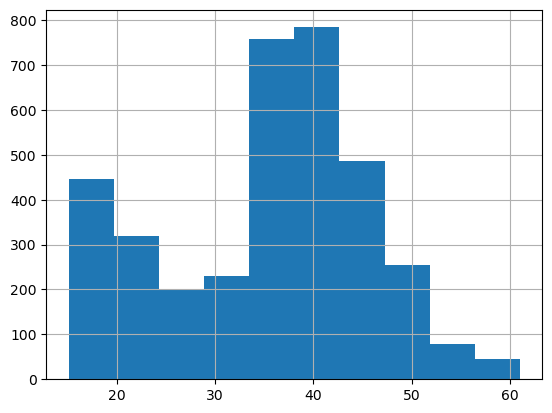

In [31]:
submission.Strength.hist()

In [32]:
submission

,Strength
id,
5407,48.652984
5408,20.264379
5409,34.191657
5410,47.180216
5411,33.169046
...,...
9007,32.970034
9008,35.728368
9009,38.786611


In [33]:
submission.to_csv('submission.csv', index=True)